In [1]:
# ============================================================================
# COMPLETE PYTORCH GEOMETRIC INSTALLATION (KAGGLE WITH GPU)
# ============================================================================

import torch
import subprocess
import sys

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Extract PyTorch version and CUDA version
torch_version = torch.__version__.split('+')[0]  # e.g., '2.0.0'
cuda_version = f"cu{torch.version.cuda.replace('.', '')}" if torch.cuda.is_available() else 'cpu'

print(f"\nDetected: PyTorch {torch_version}, CUDA {cuda_version}")

# ============================================================================
# INSTALLATION STEPS
# ============================================================================

print("\n" + "="*70)
print("Step 1: Installing torch-scatter...")
print("="*70)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch_version}+{cuda_version}.html -q

print("\n" + "="*70)
print("Step 2: Installing torch-sparse...")
print("="*70)
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{cuda_version}.html -q

print("\n" + "="*70)
print("Step 3: Installing torch-cluster...")
print("="*70)
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{cuda_version}.html -q

print("\n" + "="*70)
print("Step 4: Installing torch-spline-conv...")
print("="*70)
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{cuda_version}.html -q

print("\n" + "="*70)
print("Step 5: Installing torch-geometric (full)...")
print("="*70)
!pip install torch-geometric -q

# ============================================================================
# VERIFICATION
# ============================================================================

print("\n" + "="*70)
print("FINAL VERIFICATION")
print("="*70)

try:
    import torch_geometric
    print(f"✓ torch_geometric version: {torch_geometric.__version__}")
    
    from torch_geometric.nn import (
        GCNConv, SAGEConv, GATConv, GATv2Conv,
        global_mean_pool, global_max_pool, global_add_pool,
        MessagePassing, BatchNorm, LayerNorm
    )
    print("✓ All nn modules imported successfully")
    
    from torch_geometric.data import Data
    from torch_geometric.loader import NeighborLoader, DataLoader
    print("✓ Data loaders imported successfully")
    
    from torch_geometric.utils import dropout_edge, add_self_loops, degree
    print("✓ Utility functions imported successfully")
    
    print("\n" + "="*70)
    print("✅ PYTORCH GEOMETRIC FULLY INSTALLED AND READY!")
    print("="*70)
    
except Exception as e:
    print(f"✗ Error during verification: {e}")
    print("\nTrying alternative installation method...")
    !pip install --upgrade torch-geometric torch-scatter torch-sparse -q
    print("Alternative installation completed. Please restart kernel and verify again.")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB

Detected: PyTorch 2.6.0, CUDA cu124

Step 1: Installing torch-scatter...

Step 2: Installing torch-sparse...
  Preparing metadata (setup.py) ... done

Step 3: Installing torch-cluster...
  Preparing metadata (setup.py) ... done

Step 4: Installing torch-spline-conv...
  Preparing metadata (setup.py) ... done

Step 5: Installing torch-geometric (full)...

FINAL VERIFICATION
✓ torch_geometric version: 2.6.1
✓ All nn modules imported successfully
✓ Data loaders imported successfully
✓ Utility functions imported successfully

✅ PYTORCH GEOMETRIC FULLY INSTALLED AND READY!


In [2]:
# ============================================================================
# HIGH-CAPACITY GNN TRAINING (KAGGLE-READY)
# ============================================================================

import os

# Detect Kaggle runtime (environment variable is set inside Kaggle kernels)
RUNNING_ON_KAGGLE = bool(os.environ.get('KAGGLE_KERNEL_RUN_TYPE'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from typing import Dict, List, Tuple
import time
from tqdm.auto import tqdm
import gc

# PyTorch and PyG
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    GCNConv, SAGEConv, GATConv, GATv2Conv,
    global_mean_pool, global_max_pool, global_add_pool,
    MessagePassing, BatchNorm, LayerNorm
)
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import dropout_edge, add_self_loops, degree
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR
from torch.utils.checkpoint import checkpoint  # Optional gradient checkpointing

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f'PyTorch version: {torch.__version__}')
print(f'Running on Kaggle: {RUNNING_ON_KAGGLE}')
print(f'Using device: cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB')

PyTorch version: 2.6.0+cu124
Running on Kaggle: True
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB


# Advanced GNN Training for Fraud Detection (Kaggle Edition)

**Key Highlights:**
1. **High-Capacity Architectures**: Full-width GraphSAGE, Hybrid GNN, and UltraDeepSAGE models.
2. **Kaggle Session Workflow**: Two models per 9-hour session with automatic checkpoint persistence.
3. **Training Enhancements**: Focal loss, label smoothing, mixed precision, dynamic augmentation.
4. **Comprehensive Reporting**: Test metrics, convergence curves, ensemble evaluation, and JSON exports.

**Targets**: >85% accuracy with strong F1 scores.

**Inputs**: Preprocessed PyG graph from notebook 02.
**Outputs**: Model checkpoints and metrics stored under `models/` and `results/` (or `/kaggle/working`).

In [3]:
# Configure paths
LOCAL_DATA_PATH = Path(r'C:\Users\youss\Downloads\Flag_finance\data')
if RUNNING_ON_KAGGLE:
    BASE_PATH = Path('/kaggle/input/flag-finance')
    WORKING_ROOT = Path('/kaggle/working')
else:
    BASE_PATH = LOCAL_DATA_PATH
    WORKING_ROOT = LOCAL_DATA_PATH

GRAPHS_PATH = BASE_PATH / 'graphs'
MODELS_PATH = WORKING_ROOT / 'models'
RESULTS_PATH = WORKING_ROOT / 'results'

# Ensure output directories exist (Kaggle keeps /kaggle/working between runs)
MODELS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Set device and optimize CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.cuda.empty_cache()
    
print(f'Using device: {device}')
print(f'Data root: {BASE_PATH}')
print(f'Model output path: {MODELS_PATH}')

# Load graph data
graph_path = GRAPHS_PATH / 'elliptic_graph_data.pt'
data = torch.load(graph_path, weights_only=False).to(device)

print(f'\n📊 Loaded graph:')
print(f'   Nodes: {data.num_nodes:,}')
print(f'   Edges: {data.edge_index.size(1):,}')
print(f'   Features: {data.num_features}')
print(f'   Train nodes: {data.train_mask.sum().item():,}')
print(f'   Val nodes: {data.val_mask.sum().item():,}')
print(f'   Test nodes: {data.test_mask.sum().item():,}')


# Create mini-batch loaders to avoid OOM
BATCH_SIZE = 1024
NUM_NEIGHBORS = [15, 10]  # 2-hop sampling for most models

train_loader = NeighborLoader(
    data,
    num_neighbors=NUM_NEIGHBORS,
    batch_size=BATCH_SIZE,
    input_nodes=data.train_mask,
    shuffle=True,
    num_workers=0
)

val_loader = NeighborLoader(
    data,
    num_neighbors=NUM_NEIGHBORS,
    batch_size=BATCH_SIZE,
    input_nodes=data.val_mask,
    shuffle=False,
    num_workers=0
)

test_loader = NeighborLoader(
    data,
    num_neighbors=NUM_NEIGHBORS,
    batch_size=BATCH_SIZE,
    input_nodes=data.test_mask,
    shuffle=False,
    num_workers=0
)

print(f'\n✅ Created mini-batch loaders (batch_size={BATCH_SIZE}, neighbors={NUM_NEIGHBORS})')

Using device: cuda
Data root: /kaggle/input/flag-finance
Model output path: /kaggle/working/models

📊 Loaded graph:
   Nodes: 203,769
   Edges: 468,710
   Features: 100
   Train nodes: 136,265
   Val nodes: 42,883
   Test nodes: 24,621

✅ Created mini-batch loaders (batch_size=1024, neighbors=[15, 10])


## High-Capacity Model Architectures (Optimized for Kaggle 16GB GPU)

Kaggle's P100/V100 GPUs provide 16 GB of memory, letting us train the full-capacity models without compromise.


1. **DeepGraphSAGE (High Capacity)**:
   - Jumping knowledge, dense residual pathways
   - Feature-wise attention for richer representations
   - Designed for long training runs (600+ epochs)

2. **HybridGNN (GCN + SAGE + GAT)**:
   - Parallel aggregation paths with learned fusion
   - Higher attention head counts enabled by the larger memory budget
   - Excellent for capturing heterophily

3. **UltraDeepSAGE**:
   - 8-layer depth with LayerNorm for stability
   - Strong residual connections to avoid vanishing gradients

4. **Extended DeepSAGE Variants**:
   - Hidden sizes 320–400 for maximal accuracy
   - Dropout tuned for longer runs

Because Kaggle sessions are limited to 9 hours, we will train **two models per session**, save checkpoints, and resume with the remaining models during the next session.

In [4]:
# GPU status check
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f'GPU Memory (allocated): {torch.cuda.memory_allocated()/1e9:.2f} GB')
    print(f'GPU Memory (total): {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB')
else:
    print('Running on CPU')

# ============================================================================
# HIGH-CAPACITY GNN ARCHITECTURES (KAGGLE)
# ============================================================================

# Gradient checkpointing wrapper (optional)
class CheckpointedSAGEConv(nn.Module):
    """Wrapper for SAGEConv with optional gradient checkpointing."""
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, **kwargs)
    
    def forward(self, x, edge_index):
        return checkpoint(self.conv, x, edge_index, use_reentrant=False)


class DeepGraphSAGE(nn.Module):
    """High-capacity GraphSAGE with feature attention and jumping knowledge."""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=6, dropout=0.4, use_checkpointing=False):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.use_checkpointing = use_checkpointing

        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.PReLU(),
            nn.Dropout(dropout * 0.5)
        )

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.feature_attn = nn.ModuleList()
        for _ in range(num_layers):
            if use_checkpointing:
                conv = CheckpointedSAGEConv(hidden_channels, hidden_channels, normalize=True, root_weight=True, project=True)
            else:
                conv = SAGEConv(hidden_channels, hidden_channels, normalize=True, root_weight=True, project=True)
            self.convs.append(conv)
            self.norms.append(LayerNorm(hidden_channels))
            self.feature_attn.append(nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels // 4),
                nn.ReLU(),
                nn.Linear(hidden_channels // 4, hidden_channels),
                nn.Sigmoid()
            ))

        self.jump_linear = nn.Sequential(
            nn.Linear(hidden_channels * (num_layers + 1), hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.PReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.PReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden_channels // 2, hidden_channels // 4),
            nn.BatchNorm1d(hidden_channels // 4),
            nn.PReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_channels // 4, out_channels)
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x, edge_index):
        x = self.input_proj(x)
        layer_outputs = [x]

        for conv, norm, attn in zip(self.convs, self.norms, self.feature_attn):
            residual = x
            x = conv(x, edge_index)
            x = norm(x)
            att_weights = attn(x)
            x = x * att_weights
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = x + residual * 0.4
            layer_outputs.append(x)

        x = torch.cat(layer_outputs, dim=1)
        x = self.jump_linear(x)
        x = F.dropout(x, p=self.dropout * 0.5, training=self.training)
        return self.classifier(x)


class HybridGNN(nn.Module):
    """Hybrid GCN + SAGE + GAT model with learned fusion."""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=4, dropout=0.4, gat_heads=8, use_checkpointing=False):
        super().__init__()
        self.dropout = dropout
        self.use_checkpointing = use_checkpointing

        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU()
        )

        self.gcn_layers = nn.ModuleList()
        self.sage_layers = nn.ModuleList()
        self.gat_layers = nn.ModuleList()
        self.fusion_layers = nn.ModuleList()
        for layer_idx in range(num_layers):
            self.gcn_layers.append(
                GCNConv(hidden_channels, hidden_channels, improved=True, cached=False)
            )
            if use_checkpointing:
                sage = CheckpointedSAGEConv(hidden_channels, hidden_channels, normalize=True, root_weight=True)
            else:
                sage = SAGEConv(hidden_channels, hidden_channels, normalize=True, root_weight=True)
            self.sage_layers.append(sage)
            heads = gat_heads if layer_idx < 2 else max(4, gat_heads // 2)
            self.gat_layers.append(
                GATv2Conv(hidden_channels, hidden_channels // heads, heads=heads, dropout=dropout, concat=True)
            )
            self.fusion_layers.append(nn.Sequential(
                nn.Linear(hidden_channels * 3, hidden_channels),
                nn.LayerNorm(hidden_channels),
                nn.PReLU()
            ))

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.PReLU(),
            nn.Dropout(dropout * 0.8),
            nn.Linear(hidden_channels // 2, out_channels)
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x, edge_index):
        x = self.input_proj(x)
        gcn_out = x
        sage_out = x
        gat_out = x

        for gcn, sage, gat, fusion in zip(self.gcn_layers, self.sage_layers, self.gat_layers, self.fusion_layers):
            gcn_residual = gcn_out
            sage_residual = sage_out
            gat_residual = gat_out

            gcn_out = F.relu(gcn(gcn_out, edge_index))
            sage_out = F.relu(sage(sage_out, edge_index))
            gat_out = F.elu(gat(gat_out, edge_index))

            gcn_out = F.dropout(gcn_out, p=self.dropout, training=self.training)
            sage_out = F.dropout(sage_out, p=self.dropout, training=self.training)
            gat_out = F.dropout(gat_out, p=self.dropout, training=self.training)

            fused = fusion(torch.cat([gcn_out, sage_out, gat_out], dim=1))

            gcn_out = fused + gcn_residual * 0.3
            sage_out = fused + sage_residual * 0.3
            gat_out = fused + gat_residual * 0.3

        return self.classifier(fused)


class UltraDeepSAGE(nn.Module):
    """Ultra-deep SAGE network designed for large hidden dimensions."""
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=8, dropout=0.35, use_checkpointing=False):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.use_checkpointing = use_checkpointing

        self.input_proj = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.PReLU()
        )

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(num_layers):
            if use_checkpointing:
                conv = CheckpointedSAGEConv(hidden_channels, hidden_channels, normalize=True, root_weight=True)
            else:
                conv = SAGEConv(hidden_channels, hidden_channels, normalize=True, root_weight=True)
            self.convs.append(conv)
            self.norms.append(LayerNorm(hidden_channels))

        self.jump = nn.Linear(hidden_channels * (num_layers + 1), hidden_channels * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.PReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden_channels // 2, out_channels)
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x, edge_index):
        x = self.input_proj(x)
        layer_outputs = [x]

        for layer_idx, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            residual = x
            x = conv(x, edge_index)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if layer_idx > 0:
                x = x + residual * 0.5
            layer_outputs.append(x)

        x = torch.cat(layer_outputs, dim=1)
        x = self.jump(x)
        x = F.relu(x)
        return self.classifier(x)

print('✅ High-capacity GNN architectures ready (checkpointing optional)')

GPU Memory (allocated): 0.09 GB
GPU Memory (total): 17.06 GB
✅ High-capacity GNN architectures ready (checkpointing optional)


## Advanced Loss Functions and Training Utils

In [5]:
class FocalLoss(nn.Module):
    """Focal Loss for class imbalance"""
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        p = torch.exp(-ce_loss)
        loss = (1 - p) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        return loss


class LabelSmoothingLoss(nn.Module):
    """Label smoothing"""
    def __init__(self, classes=2, smoothing=0.1, weight=None):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.weight = weight
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        
        if self.weight is not None:
            weight_expanded = self.weight[target].unsqueeze(1)
            return torch.sum(-true_dist * pred * weight_expanded) / torch.sum(weight_expanded)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))


def compute_class_weights(data, mask):
    """Compute balanced class weights"""
    labels = data.y[mask]
    counts = torch.bincount(labels)
    weights = 1.0 / counts.float()
    weights = weights / weights.sum() * len(weights)
    return weights.to(data.x.device)


def augment_graph(data, edge_drop=0.1, feat_noise=0.05, feat_drop=0.1):
    """Graph augmentation"""
    edge_index, _ = dropout_edge(data.edge_index, p=edge_drop, training=True)
    
    x = data.x.clone()
    noise = torch.randn_like(x) * feat_noise
    x = x + noise
    
    feat_mask = torch.rand(x.size(1), device=x.device) > feat_drop
    x = x * feat_mask.float()
    
    return x, edge_index


class_weights = compute_class_weights(data, data.train_mask)
print('✅ Loss functions and utilities ready')
print(f'Class weights: {class_weights.cpu().numpy()}')

✅ Loss functions and utilities ready
Class weights: [0.38794994 1.6120502 ]


## Optimized Training Pipeline with Mixed Precision

In [6]:
def train_epoch_optimized(model, train_loader, optimizer, criterion, scaler,
                         edge_drop=0.1, feat_noise=0.02):
    """Single training epoch with mini-batchs,augmentation and mixed precision."""
    model.train()
    
    total_loss = 0
    total_samples = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        batch_size = batch.batch_size
        
        # Augment within the sampled subgraph
        x_aug = batch.x.clone()
        noise = torch.randn_like(x_aug) * feat_noise
        x_aug = x_aug + noise
        
        edge_index_aug, _ = dropout_edge(batch.edge_index, p=edge_drop, training=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            out = model(x_aug, edge_index_aug)
            # Only compute loss on seed nodes (the training nodes in this batch)
            loss = criterion(out[:batch_size], batch.y[:batch_size])
            
            l2_lambda = 5e-6
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        del x_aug, edge_index_aug, out, batch
    
    return total_loss / total_samples


@torch.no_grad()
def evaluate_detailed(model, loader):
    """Comprehensive evaluation returning numpy arrays for persistence."""
    model.eval()
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    for batch in loader:
        batch = batch.to(device)
        batch_size = batch.batch_size
        
        out = model(batch.x, batch.edge_index)
        pred = out[:batch_size].argmax(dim=1)
        prob = F.softmax(out[:batch_size], dim=1)[:, 1]
        
        all_preds.append(pred.cpu())
        all_probs.append(prob.cpu())
        all_labels.append(batch.y[:batch_size].cpu())
        
        del out, pred, prob, batch
    
    y_true = torch.cat(all_labels).numpy()
    pred_np = torch.cat(all_preds).numpy()
    prob_np = torch.cat(all_probs).numpy()
    
    metrics = {
        'accuracy': accuracy_score(y_true, pred_np),
        'precision': precision_score(y_true, pred_np, zero_division=0),
        'recall': recall_score(y_true, pred_np, zero_division=0),
        'f1': f1_score(y_true, pred_np, zero_division=0),
        'auc': roc_auc_score(y_true, prob_np) if len(np.unique(y_true)) > 1 else 0.0
    }
    
    return metrics, pred_np, prob_np

print('✅ Training utilities ready (mixed precision + augmentation)')

✅ Training utilities ready (mixed precision + augmentation)


## Advanced Training Loop with Multiple Optimizations

In [7]:
import json
from pathlib import Path

class CheckpointManager:
    """Save and resume training from any epoch"""
    
    def __init__(self, checkpoint_dir=MODELS_PATH):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
    
    def save_checkpoint(self, model, optimizer, scheduler, epoch, metrics, model_name):
        """Save model, optimizer, scheduler, and metrics"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'metrics': metrics,
        }
        path = self.checkpoint_dir / f'{model_name}_epoch_{epoch}.pt'
        torch.save(checkpoint, path)
        return path
    
    def load_checkpoint(self, model, optimizer, scheduler, checkpoint_path, device):
        """Load checkpoint and resume training"""
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        start_epoch = checkpoint['epoch'] + 1
        metrics = checkpoint.get('metrics', {})
        
        print(f'✓ Loaded checkpoint from epoch {checkpoint["epoch"]}')
        print(f'  Val Acc: {metrics.get("accuracy", 0):.4f}')
        print(f'  Val F1: {metrics.get("f1", 0):.4f}')
        
        return model, optimizer, scheduler, start_epoch, metrics
    
    def get_latest_checkpoint(self, model_name):
        """Find latest checkpoint for a model"""
        checkpoints = sorted(self.checkpoint_dir.glob(f'{model_name}_epoch_*.pt'))
        return checkpoints[-1] if checkpoints else None
    
    def list_checkpoints(self, model_name):
        """List all checkpoints for a model"""
        checkpoints = sorted(self.checkpoint_dir.glob(f'{model_name}_epoch_*.pt'))
        epochs = [int(cp.stem.split('_')[-1]) for cp in checkpoints]
        return dict(zip(epochs, checkpoints))

checkpoint_manager = CheckpointManager(MODELS_PATH)
print('✅ Checkpoint manager ready')

✅ Checkpoint manager ready


In [8]:
available = checkpoint_manager.list_checkpoints('DeepSAGE_L6_H384')
print(f"Can resume from epochs: {sorted(available.keys())}")

Can resume from epochs: []


In [9]:
def train_model_advanced(model, train_loader, val_loader, test_loader, model_name, epochs=600, lr=0.002,
                        weight_decay=3e-4, patience=70, warmup_epochs=15,
                        use_scheduler='cosine', loss_type='focal', resume_from_epoch=0):
    """Advanced training pipeline with mini-batch support, progress reporting, and resume capability."""
    
    print(f'\n{"="*70}')
    print(f'🚀 Training {model_name}')
    if resume_from_epoch > 0:
        print(f'   Resuming from epoch {resume_from_epoch}')
    print(f'{"="*70}')
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay,
                                  betas=(0.9, 0.999))
    
    # Load checkpoint if resuming
    start_epoch = 1
    best_val_acc = 0
    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []}
    
    checkpoint_path = MODELS_PATH / f'{model_name}_best.pt'
    if resume_from_epoch > 0 and checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 1) + 1
        best_val_acc = checkpoint.get('val_metrics', {}).get('accuracy', 0)
        best_val_f1 = checkpoint.get('val_metrics', {}).get('f1', 0)
        
        # Try to load history if available
        history_file = MODELS_PATH / f'{model_name}_history.json'
        if history_file.exists():
            with open(history_file, 'r') as f:
                history = json.load(f)
        
        print(f'✅ Loaded checkpoint from epoch {start_epoch - 1}')
        print(f'   Best val acc: {best_val_acc:.4f}, Best val F1: {best_val_f1:.4f}')
    
    if use_scheduler == 'cosine':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=60, T_mult=2, eta_min=5e-7)
    elif use_scheduler == 'onecycle':
        scheduler = OneCycleLR(optimizer, max_lr=lr*10, epochs=epochs,
                              steps_per_epoch=1, pct_start=0.08)
    else:
        scheduler = None
    
    # Use global data for class weights
    class_weights = compute_class_weights(data, data.train_mask)
    if loss_type == 'focal':
        criterion = FocalLoss(alpha=class_weights, gamma=2.5)
    elif loss_type == 'label_smoothing':
        criterion = LabelSmoothingLoss(smoothing=0.12, weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    scaler = GradScaler()
    
    start_time = time.time()
    with tqdm(range(start_epoch, epochs + 1), desc=f'Training {model_name}') as pbar:
        for epoch in pbar:
            edge_drop = 0.18 * (1 - epoch/epochs)
            feat_noise = 0.03 * (1 - epoch/epochs)
            
            loss = train_epoch_optimized(model, train_loader, optimizer, criterion,
                                        scaler, edge_drop, feat_noise)
            
            if scheduler:
                scheduler.step()
            
            val_metrics, _, _ = evaluate_detailed(model, val_loader)
            
            history['train_loss'].append(loss)
            history['val_acc'].append(val_metrics['accuracy'])
            history['val_f1'].append(val_metrics['f1'])
            history['val_auc'].append(val_metrics['auc'])
            
            gpu_alloc = torch.cuda.memory_allocated()/1e9 if torch.cuda.is_available() else 0
            pbar.set_postfix({
                'Loss': f'{loss:.4f}',
                'Val Acc': f'{val_metrics["accuracy"]:.4f}',
                'Val F1': f'{val_metrics["f1"]:.4f}',
                'GPU': f'{gpu_alloc:.1f}GB'
            })
            
            if val_metrics['accuracy'] > best_val_acc or \
               (val_metrics['accuracy'] == best_val_acc and val_metrics['f1'] > best_val_f1):
                best_val_acc = val_metrics['accuracy']
                best_val_f1 = val_metrics['f1']
                patience_counter = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'val_metrics': val_metrics
                }, checkpoint_path)
                
                # Save history separately for resume
                history_file = MODELS_PATH / f'{model_name}_history.json'
                with open(history_file, 'w') as f:
                    json.dump(history, f, indent=2)
                
                # Update session state every 10 epochs
                if epoch % 10 == 0:
                    persist_session_state(current_model=model_name, current_epoch=epoch)
            else:
                patience_counter += 1
            
            if patience_counter >= patience and epoch > warmup_epochs * 2:
                print(f'\n⏹️  Early stopping at epoch {epoch}')
                break
            
            if epoch % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    train_time = time.time() - start_time
    
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_metrics, test_pred, test_prob = evaluate_detailed(model, test_loader)
    
    print(f'\n📊 Test Results:')
    print(f'   Accuracy: {test_metrics["accuracy"]:.4f}')
    print(f'   Precision: {test_metrics["precision"]:.4f}')
    print(f'   Recall: {test_metrics["recall"]:.4f}')
    print(f'   F1 Score: {test_metrics["f1"]:.4f}')
    print(f'   AUC: {test_metrics["auc"]:.4f}')
    
    return {
        'test_metrics': test_metrics,
        'train_time': float(train_time),
        'epochs': epoch,
        'history': history,
        'predictions': {'pred': test_pred.tolist(), 'prob': test_prob.tolist()}
    }

print('✅ Advanced training loop ready with Kaggle progress support')

✅ Advanced training loop ready with Kaggle progress support


## High-Capacity Training Plan for Kaggle Sessions

**Kaggle constraints:**
- Weekly time quota: 30 hours
- Per-session limit: 9 hours
- GPU memory: 16 GB (P100/V100)

**Strategy:**
1. Train **two models per session** to stay within the 9-hour window.
2. Checkpoints and metrics are saved after each model (stored in `/kaggle/working`).
3. Resume by re-running this notebook in the next session; completed models are skipped automatically.
4. After all four high-capacity models finish, rerun the evaluation cells to compile the full report.

In [10]:
# Kaggle session management (continuous training with resume support)
SESSION_TRACKING_FILE = RESULTS_PATH / 'kaggle_session_tracking.json'

session_state = {'completed': [], 'results': {}, 'current_model': None, 'current_epoch': 0}
if SESSION_TRACKING_FILE.exists():
    with open(SESSION_TRACKING_FILE, 'r') as f:
        session_state = json.load(f)

completed_models = set(session_state.get('completed', []))
results = session_state.get('results', {})
current_training_model = session_state.get('current_model', None)
current_training_epoch = session_state.get('current_epoch', 0)

def normalize_result(result: Dict) -> Dict:
    return {
        'test_metrics': {k: float(v) for k, v in result['test_metrics'].items()},
        'train_time': float(result['train_time']),
        'epochs': int(result['epochs']),
        'history': {
            'train_loss': [float(x) for x in result['history']['train_loss']],
            'val_acc': [float(x) for x in result['history']['val_acc']],
            'val_f1': [float(x) for x in result['history']['val_f1']],
            'val_auc': [float(x) for x in result['history']['val_auc']]
        },
        'predictions': {
            'pred': [int(x) for x in result['predictions']['pred']],
            'prob': [float(x) for x in result['predictions']['prob']]
        }
    }

def persist_session_state(current_model=None, current_epoch=0):
    payload = {
        'completed': sorted(completed_models),
        'results': results,
        'current_model': current_model,
        'current_epoch': current_epoch
    }
    with open(SESSION_TRACKING_FILE, 'w') as f:
        json.dump(payload, f, indent=2)

if RUNNING_ON_KAGGLE:
    print('Kaggle session mode enabled (continuous training until session ends).')
    print(f'Completed models: {sorted(completed_models)}')
    if current_training_model:
        print(f'Resume training: {current_training_model} from epoch {current_training_epoch}')
    print(f'Session tracking file: {SESSION_TRACKING_FILE}')
else:
    print('Local mode detected (no automatic session limit).')

Kaggle session mode enabled (continuous training until session ends).
Completed models: []
Session tracking file: /kaggle/working/results/kaggle_session_tracking.json


In [12]:
# Prepare and train high-capacity models (2 per Kaggle session)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

SESSION_MODELS_PER_RUN = None  # Train all models without limit
models_run_this_session = 0

configs = [
    {
        'name': 'DeepSAGE_L6_H384',
        'model': DeepGraphSAGE(data.num_features, 384, 2, num_layers=6, dropout=0.4, use_checkpointing=False),
        'lr': 0.0020,
        'weight_decay': 3e-4,
        'loss_type': 'focal',
        'scheduler': 'cosine',
        'epochs': 600
    },
    {
        'name': 'HybridGNN_L4_H320',
        'model': HybridGNN(data.num_features, 320, 2, num_layers=4, dropout=0.4, gat_heads=8, use_checkpointing=False),
        'lr': 0.0022,
        'weight_decay': 2.5e-4,
        'loss_type': 'label_smoothing',
        'scheduler': 'cosine',
        'epochs': 550
    },
    {
        'name': 'UltraDeepSAGE_L8_H352',
        'model': UltraDeepSAGE(data.num_features, 352, 2, num_layers=8, dropout=0.35, use_checkpointing=False),
        'lr': 0.0018,
        'weight_decay': 2e-4,
        'loss_type': 'focal',
        'scheduler': 'cosine',
        'epochs': 650
    },
    {
        'name': 'DeepSAGE_L7_H400',
        'model': DeepGraphSAGE(data.num_features, 400, 2, num_layers=7, dropout=0.38, use_checkpointing=False),
        'lr': 0.0019,
        'weight_decay': 2.5e-4,
        'loss_type': 'label_smoothing',
        'scheduler': 'cosine',
        'epochs': 600
    }
 ]

print(f'Total configured models: {len(configs)}')
print(f'Already completed: {sorted(completed_models)}')

for config in configs:
    if config['name'] in completed_models:
        print(f'⏭️  Skipping {config["name"]} (already completed).')
        continue
    
    if SESSION_MODELS_PER_RUN is not None and models_run_this_session >= SESSION_MODELS_PER_RUN:
        print('\n⏱️ Session limit reached. Resume in the next Kaggle session to continue training.')
        break
    
    print(f'\n🚀 Training {config["name"]}...')
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    model = config['model'].to(device)
    num_params = sum(p.numel() for p in model.parameters())
    print(f'   Parameters: {num_params:,}')
    
    model_result = train_model_advanced(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        model_name=config['name'],
        epochs=config['epochs'],
        lr=config['lr'],
        weight_decay=config['weight_decay'],
        patience=70,
        warmup_epochs=15,
        use_scheduler=config['scheduler'],
        loss_type=config['loss_type']
    )
    
    results[config['name']] = normalize_result(model_result)
    completed_models.add(config['name'])
    persist_session_state()
    
    if torch.cuda.is_available():
        print(f'   GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB')
        print(f'   Peak: {torch.cuda.max_memory_allocated()/1e9:.2f} GB')
        torch.cuda.reset_peak_memory_stats()
    
  
else:
    print('\n✅ All configured models completed in this run.')

if RUNNING_ON_KAGGLE:
    remaining = [cfg['name'] for cfg in configs if cfg['name'] not in completed_models]
    if remaining:
        print(f'\nModels remaining for next session: {remaining}')
    else:
        print('\n✅ All models completed across sessions!')

Total configured models: 4
Already completed: []

🚀 Training DeepSAGE_L6_H384...
   Parameters: 4,423,399

🚀 Training DeepSAGE_L6_H384


Training DeepSAGE_L6_H384:   0%|          | 0/600 [00:00<?, ?it/s]


⏹️  Early stopping at epoch 227

📊 Test Results:
   Accuracy: 0.7755
   Precision: 0.4781
   Recall: 0.7490
   F1 Score: 0.5837
   AUC: 0.8572
   GPU Memory: 0.18 GB
   Peak: 1.16 GB

🚀 Training HybridGNN_L4_H320...
   Parameters: 3,476,648

🚀 Training HybridGNN_L4_H320


Training HybridGNN_L4_H320:   0%|          | 0/550 [00:00<?, ?it/s]


⏹️  Early stopping at epoch 141

📊 Test Results:
   Accuracy: 0.8756
   Precision: 0.7381
   Recall: 0.6321
   F1 Score: 0.6810
   AUC: 0.8475
   GPU Memory: 0.17 GB
   Peak: 0.96 GB

🚀 Training UltraDeepSAGE_L8_H352...
   Parameters: 4,569,845

🚀 Training UltraDeepSAGE_L8_H352


Training UltraDeepSAGE_L8_H352:   0%|          | 0/650 [00:00<?, ?it/s]


⏹️  Early stopping at epoch 247

📊 Test Results:
   Accuracy: 0.8005
   Precision: 0.5179
   Recall: 0.7253
   F1 Score: 0.6043
   AUC: 0.8552
   GPU Memory: 0.25 GB
   Peak: 1.03 GB

🚀 Training DeepSAGE_L7_H400...
   Parameters: 5,519,407

🚀 Training DeepSAGE_L7_H400


Training DeepSAGE_L7_H400:   0%|          | 0/600 [00:00<?, ?it/s]


⏹️  Early stopping at epoch 231

📊 Test Results:
   Accuracy: 0.8538
   Precision: 0.6500
   Recall: 0.6585
   F1 Score: 0.6542
   AUC: 0.8459
   GPU Memory: 0.30 GB
   Peak: 1.45 GB

✅ All configured models completed in this run.

✅ All models completed across sessions!


## Results Comparison and Analysis


MODEL COMPARISON - TEST SET PERFORMANCE


,Model,Accuracy,Precision,Recall,F1,AUC,Train Time (s),Epochs
0,DeepSAGE_L6_H384,0.7755,0.4781,0.7490,0.5837,0.8572,2483.2775,227
1,HybridGNN_L4_H320,0.8756,0.7381,0.6321,0.6810,0.8475,1727.2242,141
2,UltraDeepSAGE_L8_H352,0.8005,0.5179,0.7253,0.6043,0.8552,2619.3085,247
3,DeepSAGE_L7_H400,0.8538,0.6500,0.6585,0.6542,0.8459,3257.6938,231



TEST SET RANKING (by F1 Score)


,Model,Accuracy,Precision,Recall,F1,AUC
1,HybridGNN_L4_H320,0.8756,0.7381,0.6321,0.6810,0.8475
3,DeepSAGE_L7_H400,0.8538,0.6500,0.6585,0.6542,0.8459
2,UltraDeepSAGE_L8_H352,0.8005,0.5179,0.7253,0.6043,0.8552
0,DeepSAGE_L6_H384,0.7755,0.4781,0.7490,0.5837,0.8572



Best Model: HybridGNN_L4_H320 (F1 = 0.6810)


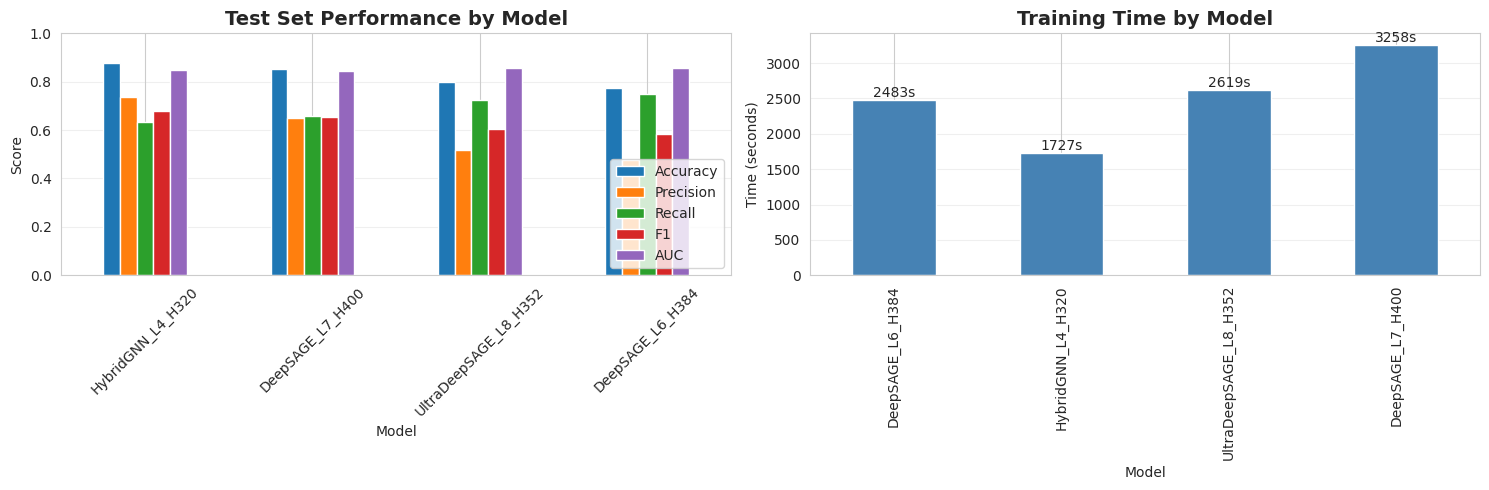

In [13]:
if not results:
    print('⚠️ No model results available yet. Train at least one model before running this cell.')
else:
    results_data = []
    for model_name, model_results in results.items():
        if model_name == 'Ensemble':
            continue
        metrics = model_results['test_metrics']
        results_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1': metrics['f1'],
            'AUC': metrics['auc'],
            'Train Time (s)': model_results['train_time'],
            'Epochs': model_results['epochs']
        })
    
    if not results_data:
        print('⚠️ No individual model results yet. Train models before running analysis.')
    else:
        results_df = pd.DataFrame(results_data)

        print('\n' + '='*70)
        print('MODEL COMPARISON - TEST SET PERFORMANCE')
        print('='*70)
        display(results_df.round(4))

        test_results = results_df.copy().sort_values('F1', ascending=False)

        print('\n' + '='*70)
        print('TEST SET RANKING (by F1 Score)')
        print('='*70)
        display(test_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].round(4))

        best_model_name = test_results.iloc[0]['Model']
        best_f1 = test_results.iloc[0]['F1']
        print(f'\nBest Model: {best_model_name} (F1 = {best_f1:.4f})')

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
        test_pivot = test_results.set_index('Model')[metrics_to_plot]

        test_pivot.plot(kind='bar', ax=axes[0], rot=45)
        axes[0].set_title('Test Set Performance by Model', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Score')
        axes[0].set_ylim([0, 1])
        axes[0].legend(loc='lower right')
        axes[0].grid(True, alpha=0.3, axis='y')

        results_df.plot(x='Model', y='Train Time (s)', kind='bar', ax=axes[1], legend=False, color='steelblue')
        axes[1].set_title('Training Time by Model', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Time (seconds)')
        axes[1].set_xlabel('Model')
        axes[1].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(results_df['Train Time (s)']):
            axes[1].text(i, v + 0.02, f'{v:.0f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

## Training Curves and Learning Dynamics

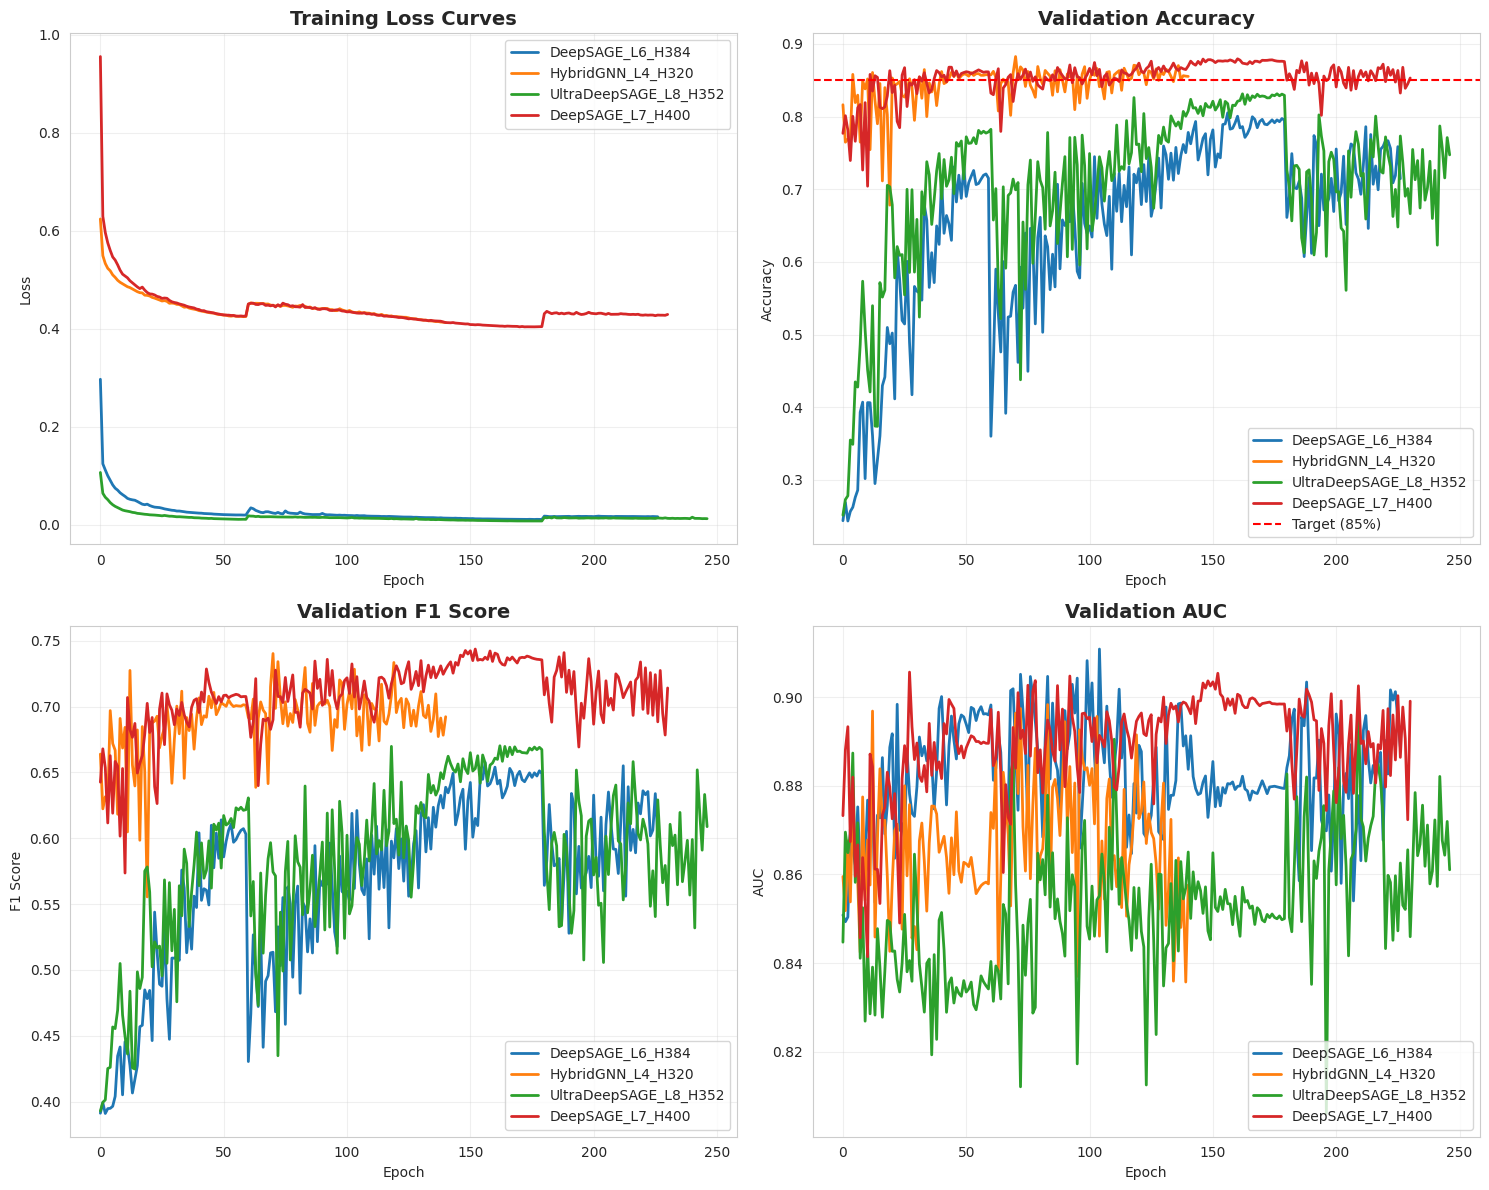


CONVERGENCE STATISTICS

DeepSAGE_L6_H384:
   Best epoch: 157
   Best val acc: 0.8051
   Best val F1: 0.6576
   Final loss: 0.0160

HybridGNN_L4_H320:
   Best epoch: 71
   Best val acc: 0.8825
   Best val F1: 0.7403
   Final loss: 0.4123

UltraDeepSAGE_L8_H352:
   Best epoch: 177
   Best val acc: 0.8312
   Best val F1: 0.6693
   Final loss: 0.0121

DeepSAGE_L7_H400:
   Best epoch: 161
   Best val acc: 0.8794
   Best val F1: 0.7407
   Final loss: 0.4290


In [14]:
if not results:
    print('⚠️ No training histories available yet. Train models before plotting curves.')
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    for model_name in results.keys():
        if model_name == 'Ensemble':
            continue
        axes[0, 0].plot(results[model_name]['history']['train_loss'], label=model_name, linewidth=2)
    axes[0, 0].set_title('Training Loss Curves', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    for model_name in results.keys():
        if model_name == 'Ensemble':
            continue
        axes[0, 1].plot(results[model_name]['history']['val_acc'], label=model_name, linewidth=2)
    axes[0, 1].axhline(y=0.85, color='r', linestyle='--', label='Target (85%)')
    axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    for model_name in results.keys():
        if model_name == 'Ensemble':
            continue
        axes[1, 0].plot(results[model_name]['history']['val_f1'], label=model_name, linewidth=2)
    axes[1, 0].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    for model_name in results.keys():
        if model_name == 'Ensemble':
            continue
        axes[1, 1].plot(results[model_name]['history']['val_auc'], label=model_name, linewidth=2)
    axes[1, 1].set_title('Validation AUC', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print('\n' + '='*70)
    print('CONVERGENCE STATISTICS')
    print('='*70)
    for model_name in results.keys():
        if model_name == 'Ensemble':
            continue
        history = results[model_name]['history']
        best_epoch = int(np.argmax(history['val_acc']))
        print(f'\n{model_name}:')
        print(f'   Best epoch: {best_epoch + 1}')
        print(f'   Best val acc: {history["val_acc"][best_epoch]:.4f}')
        print(f'   Best val F1: {history["val_f1"][best_epoch]:.4f}')
        print(f'   Final loss: {history["train_loss"][-1]:.4f}')

## Ensemble Evaluation - Boost Accuracy Further

In [23]:
if not results:
    print('⚠️ No trained models available for ensembling. Train models first.')
else:
    print('\n' + '='*70)
    print('ENSEMBLE EVALUATION')
    print('='*70)
    
    all_model_probs = []  # Store all model predictions
    loaded_models = []
    
    for config in configs:
        model_name = config['name']
        checkpoint_path = MODELS_PATH / f'{model_name}_best.pt'

        if not checkpoint_path.exists():
            print(f'⚠️ Checkpoint missing for {model_name}; skipping in ensemble.')
            continue

        model = config['model'].to(device)
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        batch_probs = []
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                batch_size = batch.batch_size
                out = model(batch.x, batch.edge_index)
                probs = F.softmax(out[:batch_size], dim=1)
                batch_probs.append(probs.cpu())
        
        # Concatenate all batches for this model
        model_probs = torch.cat(batch_probs)
        all_model_probs.append(model_probs)
        loaded_models.append(model_name)
        print(f'✅ Loaded {model_name}')

    if all_model_probs:
        # Average predictions across all models
        ensemble_probs = torch.stack(all_model_probs).mean(dim=0)
        ensemble_pred = ensemble_probs.argmax(dim=1)
        
        # Collect true labels
        ensemble_true = []
        for batch in test_loader:
            ensemble_true.append(batch.y[:batch.batch_size])
        ensemble_true = torch.cat(ensemble_true)

        acc = accuracy_score(ensemble_true.cpu(), ensemble_pred.cpu())
        precision = precision_score(ensemble_true.cpu(), ensemble_pred.cpu())
        recall = recall_score(ensemble_true.cpu(), ensemble_pred.cpu())
        f1 = f1_score(ensemble_true.cpu(), ensemble_pred.cpu())
        auc = roc_auc_score(ensemble_true.cpu(), ensemble_probs[:, 1].cpu())

        print(f'\n{"="*70}')
        print('ENSEMBLE RESULTS')
        print(f'{"="*70}')
        print(f'🎯 Accuracy: {acc*100:.2f}%')
        print(f'   Precision: {precision:.4f}')
        print(f'   Recall: {recall:.4f}')
        print(f'   F1: {f1:.4f}')
        print(f'   AUC: {auc:.4f}')

        if acc >= 0.85:
            print(f'\n✅ TARGET ACHIEVED: {acc*100:.2f}% accuracy!')
        else:
            gap = (0.85 - acc) * 100
            print(f'\n⚠️ Gap to 85%: {gap:.2f}pp')

        results['Ensemble'] = {
            'test_metrics': {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc},
            'train_time': 0.0,
            'epochs': 0,
            'history': {'train_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []},
            'predictions': {
                'pred': ensemble_pred.cpu().numpy().tolist(),
                'prob': ensemble_probs[:, 1].cpu().numpy().tolist()
            }
        }
        persist_session_state()
    else:
        print('⚠️ No models loaded for ensemble evaluation.')


ENSEMBLE EVALUATION
✅ Loaded DeepSAGE_L6_H384
✅ Loaded HybridGNN_L4_H320
✅ Loaded UltraDeepSAGE_L8_H352
✅ Loaded DeepSAGE_L7_H400

ENSEMBLE RESULTS
🎯 Accuracy: 86.59%
   Precision: 0.6834
   Recall: 0.6740
   F1: 0.6787
   AUC: 0.8665

✅ TARGET ACHIEVED: 86.59% accuracy!


## Save Results and Models

In [20]:
if not results:
    print('⚠️ No results to persist yet. Train models before saving outputs.')
else:
    local_results_df = None
    local_best_model = None
    if 'results_df' in locals() and isinstance(results_df, pd.DataFrame):
        local_results_df = results_df.copy()
    if 'best_model_name' in locals():
        local_best_model = best_model_name
    
    if local_results_df is None or local_results_df.empty or local_best_model is None:
        tabular = []
        for model_name, model_results in results.items():
            if model_name == 'Ensemble':
                continue
            metrics = model_results['test_metrics']
            tabular.append({
                'Model': model_name,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1'],
                'AUC': metrics['auc'],
                'Train Time (s)': model_results['train_time'],
                'Epochs': model_results['epochs']
            })
        local_results_df = pd.DataFrame(tabular) if tabular else pd.DataFrame()
        if not local_results_df.empty:
            local_best_model = local_results_df.sort_values('F1', ascending=False).iloc[0]['Model']
    
    results_summary = {
        'results_table': local_results_df.to_dict('records') if local_results_df is not None else [],
        'best_model': {
            'name': local_best_model,
            'test_accuracy': float(local_results_df[local_results_df['Model'] == local_best_model]['Accuracy'].iloc[0]),
            'test_f1': float(local_results_df[local_results_df['Model'] == local_best_model]['F1'].iloc[0]),
            'test_auc': float(local_results_df[local_results_df['Model'] == local_best_model]['AUC'].iloc[0])
        } if (local_results_df is not None and not local_results_df.empty and local_best_model is not None) else None,
        'training_times': {name: float(res['train_time']) for name, res in results.items() if name != 'Ensemble'},
        'ensemble_metrics': results.get('Ensemble', {}).get('test_metrics', None),
        'target_achieved': any(res['test_metrics']['accuracy'] >= 0.85 for name, res in results.items() if name != 'Ensemble')
    }
    
    results_file = RESULTS_PATH / 'gnn_kaggle_results.json'
    with open(results_file, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    training_histories = {
        model_name: {
            'train_loss': [float(x) for x in res['history']['train_loss']],
            'val_acc': [float(x) for x in res['history']['val_acc']],
            'val_f1': [float(x) for x in res['history']['val_f1']],
            'val_auc': [float(x) for x in res['history']['val_auc']]
        }
        for model_name, res in results.items() if model_name != 'Ensemble'
    }
    
    history_file = RESULTS_PATH / 'training_histories_kaggle.json'
    with open(history_file, 'w') as f:
        json.dump(training_histories, f, indent=2)
    
    print(f'Results saved to: {results_file}')
    print(f'Training histories saved to: {history_file}')

Results saved to: /kaggle/working/results/gnn_kaggle_results.json
Training histories saved to: /kaggle/working/results/training_histories_kaggle.json


## Export GNN Embeddings for Fusion

In [ ]:
# Generate node embeddings from saved checkpoints without retraining
import pickle

processed_candidates = [
    BASE_PATH / 'processed',
    BASE_PATH / 'data' / 'processed',
    WORKING_ROOT / 'processed',
    WORKING_ROOT / 'data' / 'processed'
]
PROCESSED_PATH = next((p for p in processed_candidates if p.exists()), processed_candidates[0])

# Ensure we write to a directory that is actually writable (Kaggle input mounts are read-only)
if not os.access(PROCESSED_PATH, os.W_OK):
    PROCESSED_PATH = WORKING_ROOT / 'processed'
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

EXPORT_MODELS = {
    'HybridGNN_L4_H320': {
        'builder': lambda: HybridGNN(
            data.num_features,
            320,
            2,
            num_layers=4,
            dropout=0.4,
            gat_heads=8,
            use_checkpointing=False
        ),
        'checkpoint': MODELS_PATH / 'HybridGNN_L4_H320_best.pt'
    }
}


def capture_penultimate_embeddings(model: nn.Module) -> torch.Tensor:
    """Capture the hidden representation just before the classifier head."""
    captured = {}

    def hook(module, inputs, _output):
        captured['emb'] = inputs[0].detach().cpu()

    handle = model.classifier[0].register_forward_hook(hook)
    with torch.no_grad():
        _ = model(data.x, data.edge_index)
    handle.remove()

    if 'emb' not in captured:
        raise RuntimeError('Failed to capture embeddings via forward hook.')
    return captured['emb']


labels_np = data.y.detach().cpu().numpy()
masks = {
    'train': data.train_mask.detach().cpu().numpy().astype(bool),
    'val': data.val_mask.detach().cpu().numpy().astype(bool),
    'test': data.test_mask.detach().cpu().numpy().astype(bool)
}

gnn_embeddings = {}

for model_name, cfg in EXPORT_MODELS.items():
    ckpt_path = cfg['checkpoint']
    if not ckpt_path.exists():
        print(f'⚠️ Skipping {model_name}: checkpoint not found at {ckpt_path}')
        continue

    model = cfg['builder']().to(device)
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    embedding_tensor = capture_penultimate_embeddings(model)
    embeddings_np = embedding_tensor.numpy().astype(np.float32)

    gnn_embeddings[model_name] = {}
    for split_name, mask in masks.items():
        gnn_embeddings[model_name][split_name] = {
            'embeddings': embeddings_np[mask],
            'labels': labels_np[mask]
        }
        print(f'{model_name} | {split_name}: {embeddings_np[mask].shape}')

output_path = PROCESSED_PATH / 'gnn_embeddings.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(gnn_embeddings, f)

print(f'✅ Saved GNN embeddings to: {output_path}')

## Final Summary

In [21]:
print('\n' + '='*80)
print(' ' * 25 + 'TRAINING COMPLETE')
print('='*80)

if not results:
    print('\n⚠️ No models have been trained yet in this session.')
    if RUNNING_ON_KAGGLE:
        print('Run the training cell to process two models per session, then resume next time.')
else:
    evaluated_models = [name for name in results.keys() if name != 'Ensemble']
    best_acc = max(results[name]['test_metrics']['accuracy'] for name in evaluated_models)
    best_model = max(evaluated_models, key=lambda x: results[x]['test_metrics']['accuracy'])
    
    print(f'\n🏆 Best Single Model: {best_model}')
    print(f'   Accuracy: {best_acc*100:.2f}%')
    
    if 'Ensemble' in results:
        ensemble_acc = results['Ensemble']['test_metrics']['accuracy']
        print(f'\n🎯 Ensemble Accuracy: {ensemble_acc*100:.2f}%')
    
    print(f'\n📁 Models saved to: {MODELS_PATH}')
    if RUNNING_ON_KAGGLE:
        print(f'🗂️  Session tracking file: {SESSION_TRACKING_FILE}')


                         TRAINING COMPLETE

🏆 Best Single Model: HybridGNN_L4_H320
   Accuracy: 87.56%

🎯 Ensemble Accuracy: 86.56%

📁 Models saved to: /kaggle/working/models
🗂️  Session tracking file: /kaggle/working/results/kaggle_session_tracking.json


In [ ]:
# Generate node embeddings from saved checkpoints without retraining
import pickle
import errno

processed_candidates = [
    BASE_PATH / 'processed',
    BASE_PATH / 'data' / 'processed',
    WORKING_ROOT / 'processed',
    WORKING_ROOT / 'data' / 'processed'
]
PROCESSED_PATH = next((p for p in processed_candidates if p.exists()), processed_candidates[0])

# Pick a writable output directory (Kaggle input mounts are read-only)
if PROCESSED_PATH.is_dir() and os.access(PROCESSED_PATH, os.W_OK):
    OUTPUT_PROCESSED_PATH = PROCESSED_PATH
else:
    OUTPUT_PROCESSED_PATH = WORKING_ROOT / 'processed'
    OUTPUT_PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

EXPORT_MODELS = {
    'HybridGNN_L4_H320': {
        'builder': lambda: HybridGNN(
            data.num_features,
            320,
            2,
            num_layers=4,
            dropout=0.4,
            gat_heads=8,
            use_checkpointing=False
        ),
        'checkpoint': MODELS_PATH / 'HybridGNN_L4_H320_best.pt'
    }
}


def capture_penultimate_embeddings(model: nn.Module) -> torch.Tensor:
    """Capture the hidden representation just before the classifier head."""
    captured = {}

    def hook(module, inputs, _output):
        captured['emb'] = inputs[0].detach().cpu()

    handle = model.classifier[0].register_forward_hook(hook)
    with torch.no_grad():
        _ = model(data.x, data.edge_index)
    handle.remove()

    if 'emb' not in captured:
        raise RuntimeError('Failed to capture embeddings via forward hook.')
    return captured['emb']


labels_np = data.y.detach().cpu().numpy()
masks = {
    'train': data.train_mask.detach().cpu().numpy().astype(bool),
    'val': data.val_mask.detach().cpu().numpy().astype(bool),
    'test': data.test_mask.detach().cpu().numpy().astype(bool)
}

gnn_embeddings = {}

for model_name, cfg in EXPORT_MODELS.items():
    ckpt_path = cfg['checkpoint']
    if not ckpt_path.exists():
        print(f'⚠️ Skipping {model_name}: checkpoint not found at {ckpt_path}')
        continue

    model = cfg['builder']().to(device)
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    embedding_tensor = capture_penultimate_embeddings(model)
    embeddings_np = embedding_tensor.numpy().astype(np.float32)

    gnn_embeddings[model_name] = {}
    for split_name, mask in masks.items():
        gnn_embeddings[model_name][split_name] = {
            'embeddings': embeddings_np[mask],
            'labels': labels_np[mask]
        }
        print(f'{model_name} | {split_name}: {embeddings_np[mask].shape}')

output_path = OUTPUT_PROCESSED_PATH / 'gnn_embeddings.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(gnn_embeddings, f)

print(f'✅ Saved GNN embeddings to: {output_path}')

📦 PACKAGING MODELS AND RESULTS FOR DOWNLOAD

📁 Packaging models...
   ✓ models/HybridGNN_L4_H320_best.pt
   ✓ models/DeepSAGE_L6_H384_history.json
   ✓ models/UltraDeepSAGE_L8_H352_best.pt
   ✓ models/DeepSAGE_L7_H400_best.pt
   ✓ models/DeepSAGE_L6_H384_best.pt
   ✓ models/DeepSAGE_L7_H400_history.json
   ✓ models/HybridGNN_L4_H320_history.json
   ✓ models/UltraDeepSAGE_L8_H352_history.json

📊 Packaging results...
   ✓ results/gnn_kaggle_results.json
   ✓ results/kaggle_session_tracking.json
   ✓ results/training_histories_kaggle.json

✅ PACKAGING COMPLETE

📦 Archive: gnn_outputs_20251015_152538.zip
📏 Size: 163.4 MB

💾 Kaggle Download Instructions:
   1. File location: /kaggle/working/gnn_outputs_20251015_152538.zip
   2. Click "Save Version" (commit notebook)
   3. Go to Output tab → Download gnn_outputs_20251015_152538.zip

📂 Archive contains:
   • models/ (all .pt checkpoint files)
   • results/ (all .json metric files)
